In [100]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
np.set_printoptions(precision =4, suppress=True)

In [101]:
import PIL.Image
from io import StringIO
from io import BytesIO
import IPython.display

def showArray(a, fmt='png'):
    """Display an array image RAW without any resizing."""
    if a.ndim==2:
        a=np.uint8(a)
    elif a.ndim==3 and a.shape[2]==3:
        pass
    else:
        raise Exception('only 2d and 3d arrays with 3 colors supported')
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [102]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies a polygon image mask defined by vertices image mask."""
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, thickness=2, color=[255, 0, 0]):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Detect Hough lines"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


def weighted_img(initial_img, x, img, y, z):
    """initial_img * z + img * y + z"""
    return cv2.addWeighted(initial_img, x, img, y, z)

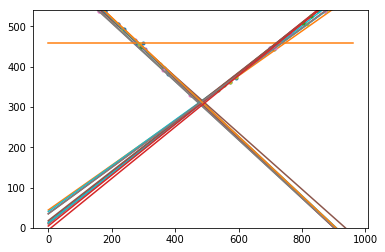

[  -0.7222  654.2778]
[ 530.4094   -2.1963]
[  0.5767  34.9755]
[ 30.2983  -1.0477]
[  0.6168  14.2243]
[ 12.1065  -1.0181]
[  -0.7273  655.3636]
[ 530.0162   -2.1996]
[  -0.7308  662.5   ]
[ 534.8966   -2.2019]
[  0.5556  44.1111]
[ 38.56    -1.0637]
[  -0.7397  666.7397]
[ 536.0235   -2.2077]
[  -0.7407  669.2222]
[ 537.7583   -2.2083]
[  -0.7241  653.1379]
[ 529.0039   -2.1975]
[  0.569   40.1552]
[ 34.9014  -1.0535]
[  -0.7381  670.119 ]
[ 539.1604   -2.2066]
[  0.6204  11.0648]
[ 9.4025 -1.0155]
[  -0.7  655.8]
[ 537.2523   -2.1815]
[ 0.625  9.375]
[ 7.95   -1.0122]
[  0.6111  12.8333]
[ 10.9505  -1.0222]
[   0.  460.]
[ 460.       -1.5708]
[ 0.6316  4.4737]
[ 3.7825 -1.0075]
[  0.6129  17.9677]
[ 15.3193  -1.0209]
[  0.5759  34.6203]
[ 30.0002  -1.0482]
[  -0.7347  667.1224]
[ 537.6218   -2.2044]
[  -0.7377  669.3115]
[ 538.6111   -2.2064]
[ 0.64 -5.56]
[ 4.683  -1.0015]


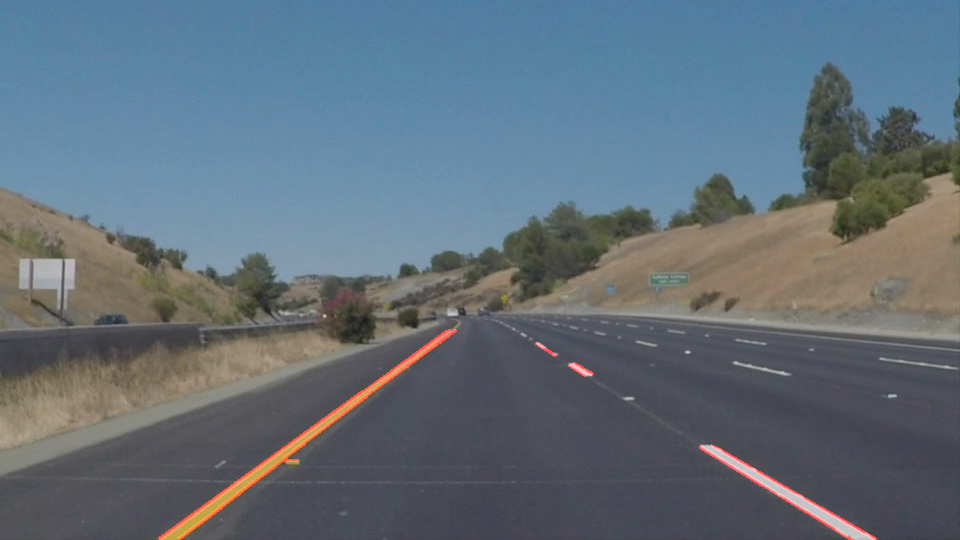

In [134]:

def mb2Hessian(m,b):
    '''returns rho and theta (from y=mx+b)'''
    D = np.sqrt(m**2 + 1)
    p =  math.fabs(b)/D
    theta = math.atan2(-1,m)
    return np.array([p,theta])

def linesPoints2MB(lines):
    linesPoints = np.reshape(lines,(-1,2,2),'F')

    xp = np.linspace(0, 960, 100)

    linesMB = np.zeros(int(linesPoints.size/2)).reshape(-1,2)    
    for i in range(0,linesPoints.shape[0]):
        x,y = linesPoints[i]
        mb = np.polyfit(x,y,1)
        linesMB[i] = mb
        
        p = np.poly1d(mb)
        _=plt.plot(x,y,'.',xp, p(xp), '-')
    plt.ylim(0,540)
    plt.show()

    return(linesMB)

def linesMBtoPolar(linesMB):
    linesPolar = np.zeros(linesMB.size).reshape(-1,2)
    for i in range(0,linesMB.shape[0]):
        print(linesMB[i])
        m,b = linesMB[i]
        polar = mb2Hessian(m,b)
        print(polar)
        linesPolar[i] = polar
    return(linesPolar)

def detectLaneLines(img):
    imgGray = grayscale(img)
    imgBlurred = gaussian_blur(imgGray, 5)
    imgEdges = canny(imgBlurred, 50, 150)
    
    x1=80
    x2=420
    x3=555
    x4=960
    y14=540
    y23=330

    vertices = np.array([[(x1, y14), (x2, y23), (x3, y23), (x4, y14)]], dtype=np.int32)
    imgMasked = region_of_interest(imgEdges, vertices)
    
    rho = 2                       # distance resolution in pixels of the Hough grid
    theta_deg = 90
    theta = np.pi/theta_deg       # angular resolution in radians of the Hough grid
    threshold = 23                # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15          # minimum number of pixels making up a line
    max_line_gap = 7             # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(imgMasked, rho, theta, threshold, min_line_len, max_line_gap)
        
    linesMB = linesPoints2MB(lines)

    linesPolar = linesMBtoPolar(linesMB)
    
    imgHoughLines = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(imgHoughLines, lines, 2)
    
    imgHoughLinesComp = weighted_img(img, 0.8, imgHoughLines, 1, 0)
    
    showArray(imgHoughLinesComp)
    
    return { 'gray' : imgGray,
             'blurred' : imgBlurred,
             'edges' : imgEdges,
             'masked': imgMasked,
             'houghLines': imgHoughLines,
             'houghLinesComp': imgHoughLinesComp }
    
img = mpimg.imread('test_images/solidYellowCurve2.jpg')
output = detectLaneLines(img)

test_images/solidWhiteCurve.jpg
[[[514 330 614 387]]

 [[532 339 877 538]]

 [[726 442 842 508]]

 [[293 462 353 412]]

 [[280 460 315 434]]

 [[618 383 694 426]]

 [[527 333 610 380]]

 [[814 491 897 539]]

 [[323 426 345 410]]

 [[281 460 344 411]]

 [[840 517 876 539]]

 [[713 435 745 454]]

 [[328 432 350 414]]

 [[783 484 799 494]]

 [[693 424 709 434]]

 [[656 404 691 423]]

 [[541 340 632 392]]]
[514 614] [330 387]
[532 877] [339 538]
[726 842] [442 508]
[293 353] [462 412]
[280 315] [460 434]
[618 694] [383 426]
[527 610] [333 380]
[814 897] [491 539]
[323 345] [426 410]
[281 344] [460 411]
[840 876] [517 539]
[713 745] [435 454]
[328 350] [432 414]
[783 799] [484 494]
[693 709] [424 434]
[656 691] [404 423]
[541 632] [340 392]
[ 32.1621  -1.0527]
[ 27.8373  -1.0476]
[ 25.1458  -1.0535]
[ 542.4923   -2.2655]
[ 536.2329   -2.2097]
[ 29.0193  -1.0559]
[ 30.0891  -1.0556]
[ 17.5323  -1.0465]
[ 534.501    -2.1996]
[ 535.6193   -2.2318]
[ 3.1287 -1.0222]
[ 10.0227  -1.035 ]
[ 542.05

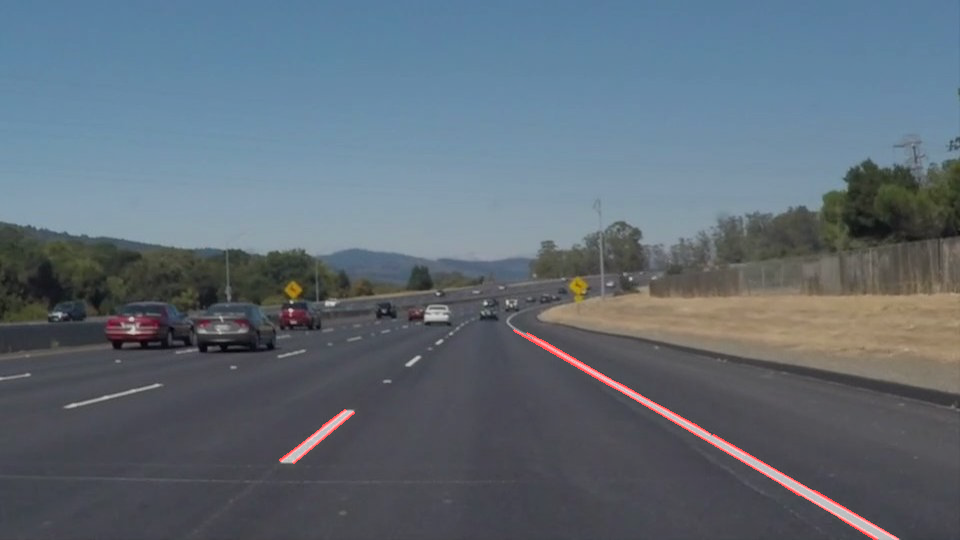

test_images_output/solidWhiteCurve_houghLines.jpg
test_images/solidWhiteRight.jpg
[[[520 330 853 538]]

 [[549 352 669 432]]

 [[310 422 355 392]]

 [[774 501 831 537]]

 [[319 425 362 394]]

 [[689 445 763 492]]

 [[517 331 583 375]]

 [[764 494 787 508]]

 [[318 425 363 392]]

 [[638 410 668 431]]

 [[310 423 357 392]]

 [[514 330 534 344]]

 [[730 472 773 499]]

 [[164 526 179 516]]

 [[670 432 693 446]]]
[520 853] [330 538]
[549 669] [352 432]
[310 355] [422 392]
[774 831] [501 537]
[319 362] [425 394]
[689 763] [445 492]
[517 583] [331 375]
[764 787] [494 508]
[318 363] [425 392]
[638 668] [410 431]
[310 357] [423 392]
[514 534] [330 344]
[730 773] [472 499]
[164 179] [526 516]
[670 693] [432 446]
[ 4.4063 -1.0125]
[ 11.6487  -0.9828]
[ 523.0823   -2.1588]
[ 10.2794  -1.0075]
[ 531.3017   -2.1954]
[ 6.2397 -1.0049]
[ 11.3714  -0.9828]
[ 24.7346  -1.024 ]
[ 530.7758   -2.2035]
[ 29.9839  -0.9601]
[ 523.7932   -2.1539]
[ 24.4131  -0.9601]
[ 11.5413  -1.0101]
[ 528.6293   -2.1588]
[ 

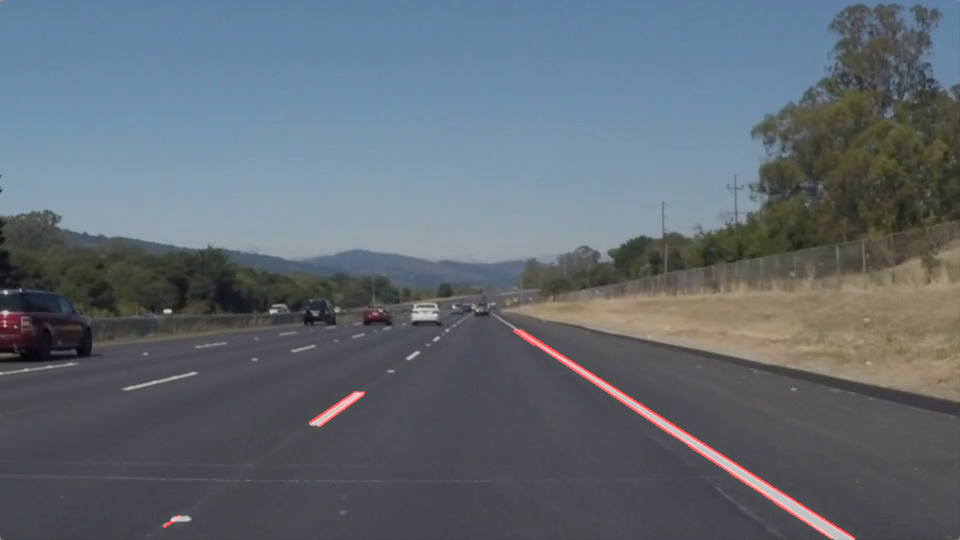

test_images_output/solidWhiteRight_houghLines.jpg
test_images/solidYellowCurve.jpg
[[[234 481 362 394]]

 [[380 381 446 330]]

 [[199 519 377 389]]

 [[174 538 240 490]]

 [[612 391 658 417]]

 [[154 538 218 494]]

 [[388 379 438 342]]

 [[606 393 648 419]]

 [[526 339 541 348]]

 [[302 434 377 383]]

 [[525 339 549 354]]

 [[611 391 635 405]]

 [[770 491 792 491]]

 [[632 408 648 418]]

 [[413 360 450 331]]

 [[359 401 385 383]]

 [[193 510 213 497]]

 [[233 482 264 462]]

 [[292 452 307 441]]

 [[394 370 409 358]]

 [[155 538 184 518]]

 [[532 344 548 354]]

 [[189 527 263 473]]

 [[327 425 355 404]]]
[234 362] [481 394]
[380 446] [381 330]
[199 377] [519 389]
[174 240] [538 490]
[612 658] [391 417]
[154 218] [538 494]
[388 438] [379 342]
[606 648] [393 419]
[526 541] [339 348]
[302 377] [434 383]
[525 549] [339 354]
[611 635] [391 405]
[770 792] [491 491]
[632 648] [408 418]
[413 450] [360 331]
[359 385] [401 383]
[193 213] [510 497]
[233 264] [482 462]
[292 307] [452 441]
[394 409]

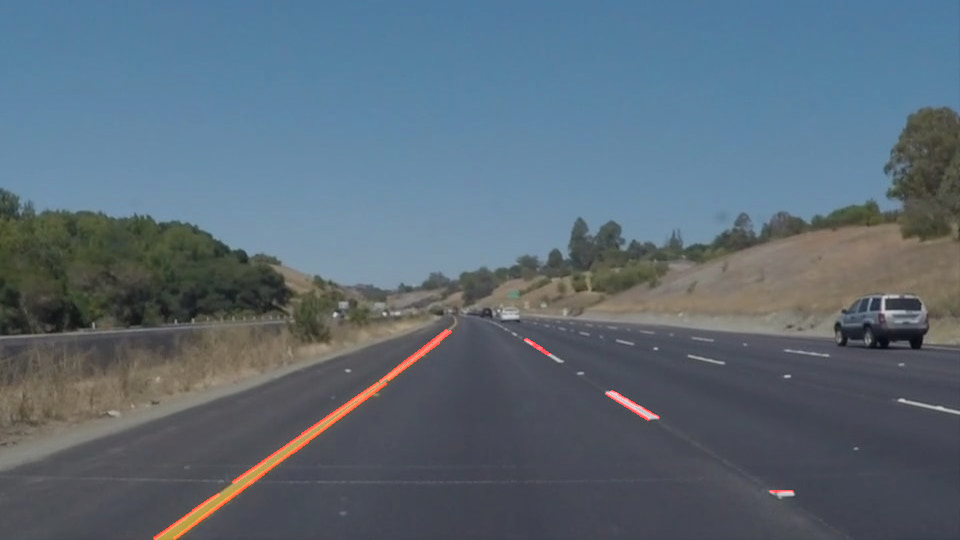

test_images_output/solidYellowCurve_houghLines.jpg
test_images/solidYellowCurve2.jpg
[[[377 382 449 330]]

 [[711 445 874 539]]

 [[700 446 807 512]]

 [[160 539 446 331]]

 [[351 406 455 330]]

 [[574 363 592 373]]

 [[293 450 366 396]]

 [[219 507 273 467]]

 [[159 538 362 391]]

 [[817 505 875 538]]

 [[179 538 221 507]]

 [[743 472 851 539]]

 [[284 457 304 443]]

 [[569 365 585 375]]

 [[573 363 591 374]]

 [[281 460 298 460]]

 [[536 343 555 355]]

 [[700 447 762 485]]

 [[716 447 874 538]]

 [[237 493 286 457]]

 [[178 538 239 493]]

 [[804 509 829 525]]]
[377 449] [382 330]
[711 874] [445 539]
[700 807] [446 512]
[160 446] [539 331]
[351 455] [406 330]
[574 592] [363 373]
[293 366] [450 396]
[219 273] [507 467]
[159 362] [538 391]
[817 875] [505 538]
[179 221] [538 507]
[743 851] [472 539]
[284 304] [457 443]
[569 585] [365 375]
[573 591] [363 374]
[281 298] [460 460]
[536 555] [343 355]
[700 762] [447 485]
[716 874] [447 538]
[237 286] [493 457]
[178 239] [538 493]
[804 829] [

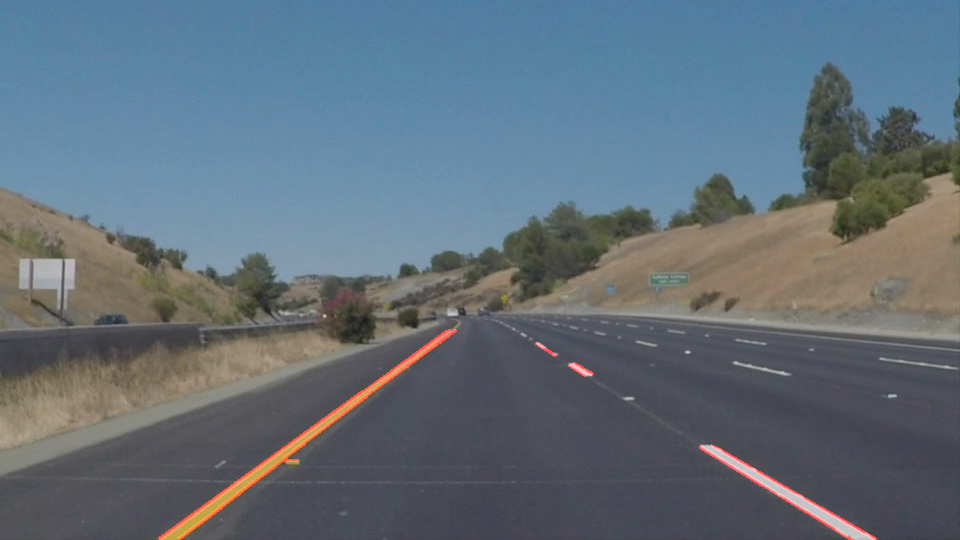

test_images_output/solidYellowCurve2_houghLines.jpg
test_images/solidYellowLeft.jpg
[[[138 539 329 410]]

 [[251 473 405 361]]

 [[359 389 439 331]]

 [[661 426 769 493]]

 [[427 343 445 330]]

 [[689 434 784 493]]

 [[672 424 756 476]]

 [[339 403 360 387]]

 [[157 538 223 493]]

 [[214 498 259 467]]

 [[561 355 579 368]]

 [[382 372 406 354]]

 [[280 442 308 424]]

 [[395 368 437 336]]

 [[559 357 575 368]]

 [[710 457 768 493]]

 [[165 534 199 510]]

 [[254 470 400 364]]

 [[531 338 546 348]]

 [[661 425 681 437]]

 [[318 417 350 394]]

 [[558 358 573 368]]

 [[140 537 293 434]]

 [[405 355 422 343]]]
[138 329] [539 410]
[251 405] [473 361]
[359 439] [389 331]
[661 769] [426 493]
[427 445] [343 330]
[689 784] [434 493]
[672 756] [424 476]
[339 360] [403 387]
[157 223] [538 493]
[214 259] [498 467]
[561 579] [355 368]
[382 406] [372 354]
[280 308] [442 424]
[395 437] [368 336]
[559 575] [357 368]
[710 768] [457 493]
[165 199] [534 510]
[254 400] [470 364]
[531 546] [338 348]
[661 681

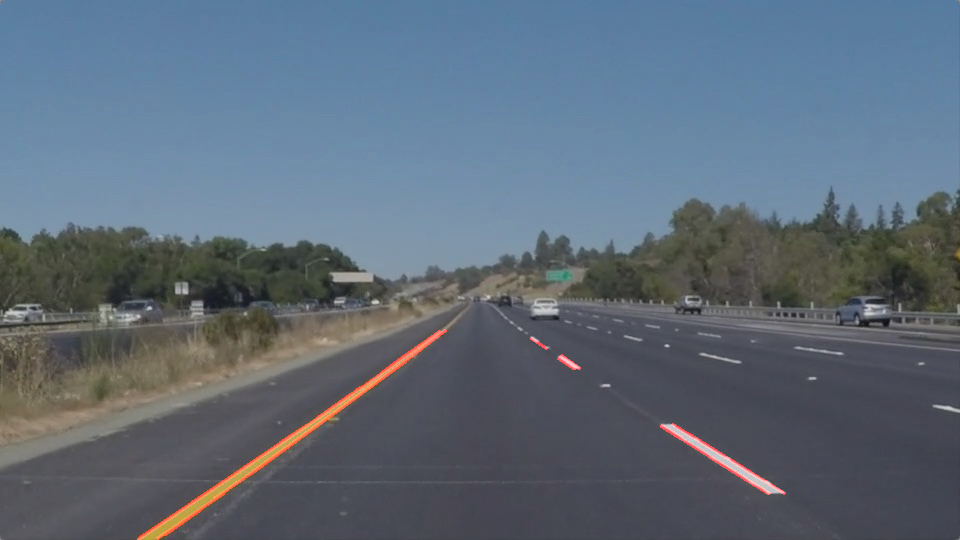

test_images_output/solidYellowLeft_houghLines.jpg
test_images/whiteCarLaneSwitch.jpg
[[[194 538 432 353]]

 [[309 438 454 332]]

 [[743 467 818 511]]

 [[190 527 303 444]]

 [[754 465 807 495]]

 [[846 518 870 531]]

 [[582 371 604 383]]

 [[780 479 873 532]]

 [[804 503 863 539]]

 [[430 356 462 330]]

 [[584 368 607 380]]

 [[517 331 533 340]]

 [[184 533 200 520]]

 [[311 437 326 427]]

 [[413 338 431 330]]

 [[195 539 216 523]]

 [[511 330 530 340]]

 [[314 444 411 368]]

 [[322 429 446 339]]

 [[265 484 282 484]]

 [[518 330 533 339]]

 [[258 489 286 468]]

 [[260 488 282 488]]

 [[783 491 834 522]]

 [[223 504 251 483]]

 [[581 371 600 382]]

 [[821 503 854 522]]

 [[416 366 436 350]]]
[194 432] [538 353]
[309 454] [438 332]
[743 818] [467 511]
[190 303] [527 444]
[754 807] [465 495]
[846 870] [518 531]
[582 604] [371 383]
[780 873] [479 532]
[804 863] [503 539]
[430 462] [356 330]
[584 607] [368 380]
[517 533] [331 340]
[184 200] [533 520]
[311 326] [437 427]
[413 431] [338 330]

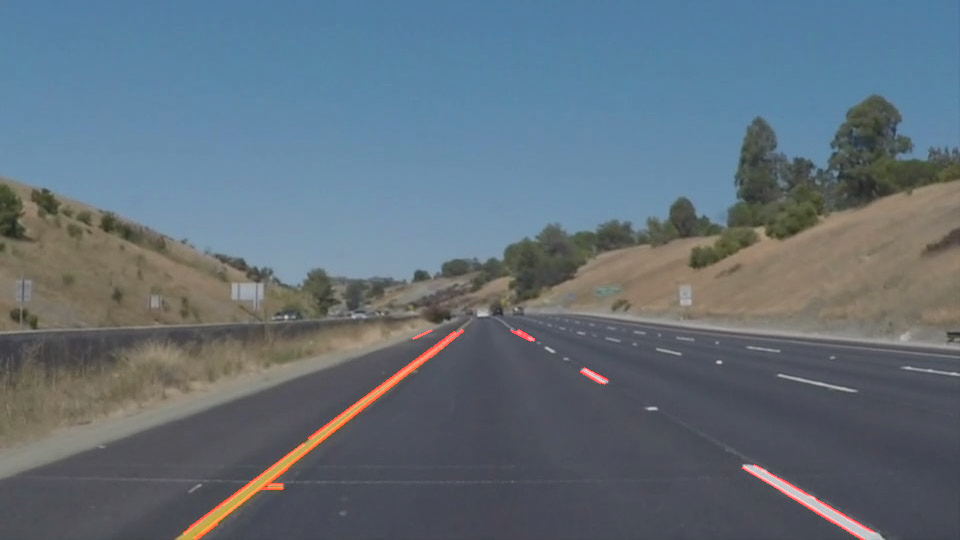

test_images_output/whiteCarLaneSwitch_houghLines.jpg


In [120]:
import os

inputFolder = 'test_images/'
outputFolder = 'test_images_output/'

for fileName in os.listdir(inputFolder):
    fileNameSplit = os.path.splitext(fileName)
    
    inFileName = inputFolder+fileName
    print(inFileName)
    img = mpimg.imread(inFileName)
    
    outImages = detectLaneLines(img)
    
    outFileName = '{0}{1}_{2}.jpg'.format(outputFolder, fileNameSplit[0],'houghLines')
    print(outFileName)
    mpimg.imsave(outFileName, outImages['houghLines'], vmin=None, vmax=None, cmap=None, format=None, origin=None, dpi=100)
    